# How to implement a neural network (1/5) - gradient descent

This page is the first part of this introduction on how to implement a neural network from scratch with Python and NumPy. This first part will illustrate the concept of gradient descent illustrated on a very simple linear regression model. The linear regression model will be approached as a minimal regression neural network. The model will be optimized using gradient descent, for which the gradient derivations are provided.

This is the first part of a 5-part tutorial on how to implement neural networks from scratch in Python:
- [Part 1: Gradient descent (this)]({% post_url /blog/neural_net_implementation/2015-06-12-neural-network-implementation-part01 %})
- [Part 2: Classification]({% post_url /blog/neural_net_implementation/2015-06-13-neural-network-implementation-part02 %})
- [Part 3: Hidden layers trained by backpropagation]({% post_url /blog/neural_net_implementation/2015-06-14-neural-network-implementation-part03 %})
- [Part 4: Vectorization of the operations]({% post_url /blog/neural_net_implementation/2015-06-15-neural-network-implementation-part04 %})
- [Part 5: Generalization to multiple layers]({% post_url /blog/neural_net_implementation/2015-06-16-neural-network-implementation-part05 %})


## Gradient descent for linear regression

In what follows we will go into the details of [gradient descent](http://en.wikipedia.org/wiki/Gradient_descent) illustrated on a very simple network: a 1-input 1-output [linear regression](https://en.wikipedia.org/wiki/Linear_regression) model that has the goal to predict the target value $t$ from the input value $x$. The network is defined as having an input $\mathbf{x}$ which gets transformed by the weight $w$ to generate the output $\mathbf{y}$ by the formula $\mathbf{y} = w \cdot \mathbf{x}$, and where $\mathbf{y}$ needs to approximate the targets $\mathbf{t}$ as good as possible as defined by a loss function. This network can be represented graphically as:

![Image of the simple neural network](/images/neural_net_implementation/SimpleANN01.png)

In practice, we typically have multiple layers, non-linear activation functions, and a bias for each node. In this tutorial, we only have one layer with one weight parameter $w$, no activation function on the output, and no bias. We will discuss hidden layers in [part 3]({% post_url /blog/neural_net_implementation/2015-06-14-neural-network-implementation-part03 %}) of this series.

We will approximate the targets $\mathbf{t}$ with the outputs of the model $y$ by minimizing the squared error between target and output. This minimization will be performed by the gradient descent optimization algorithm which is typically used in training of neural networks.

In [1]:
# Imports
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import numpy as np  # Matrix and vector computation package
import matplotlib
import matplotlib.pyplot as plt  # Plotting library
import seaborn as sns  # Fancier plots

# Set seaborn plotting style
sns.set_style('darkgrid')
# Set the seed for reproducability
np.random.seed(seed=13)
#

## Generating a toy dataset

In this example, the targets $\mathbf{t}$ will be generated from a function $f$ and additive [Gaussian noise](http://en.wikipedia.org/wiki/Normal_distribution) sampled from $\mathcal{N}(0, 0.2)$, where $\mathcal{N}$ is the normal distribution with mean 0 and variance 0.2. $f$ is defined as $f(x) = 2 x$, with $\mathbf{x}$ the input samples, slope $2$ and intercept $0$. $\mathbf{t}$ is $f(\mathbf{x}) + \mathcal{N}(0, 0.2)$. 

We will sample 20 input samples $\mathbf{x}$ from the uniform distribution between 0 and 1, and then generate the target output values $\mathbf{t}$ by the process described above. These resulting inputs $\mathbf{x}$ and targets $\mathbf{t}$ are plotted against each other in the figure below together with the original $f(x)$ line without the gaussian noise.
Note that $\mathbf{x}$ is a vector of individual input samples $x_i$, and that $\mathbf{t}$ is a corresponding vector of target values $t_i$.

In [2]:
# Define the vector of input samples as x, with 20 values 
# sampled from a uniform distribution between 0 and 1
x = np.random.uniform(0, 1, 20)

# Generate the target values t from x with small gaussian noise 
# so the estimation won't be perfect.
# Define a function f that represents the line that generates t 
# without noise.
def f(x): 
    return x * 2

# Create the targets t with some gaussian noise
noise_variance = 0.2  # Variance of the gaussian noise
# Gaussian noise error for each sample in x
noise = np.random.randn(x.shape[0]) * noise_variance
# Create targets t
t = f(x) + noise
#

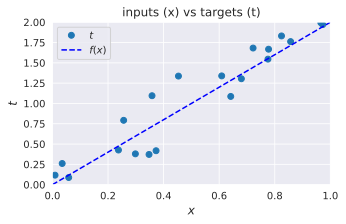

In [3]:
# Plot the target t versus the input x
plt.figure(figsize=(5, 3))
plt.plot(x, t, 'o', label='$t$')
# Plot the initial line
plt.plot([0, 1], [f(0), f(1)], 'b--', label='$f(x)$')
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$t$', fontsize=12)
plt.axis((0, 1, 0, 2))
plt.title('inputs (x) vs targets (t)')
plt.legend(loc=2)
plt.show()
#

## Define the loss function

We will optimize the model $\mathbf{y} = \mathbf{x} * w$ by tuning parameter $w$ so that the [mean squared error (MSE)](https://en.wikipedia.org/wiki/Mean_squared_error) along all samples is minimized. The function to minimizize is also known as the [loss (or cost) function](https://en.wikipedia.org/wiki/Loss_function).

The mean squared error is defined as $\xi = \frac{1}{N} \sum_{i=1}^{N} \Vert t_i - y_i \Vert ^2$, with $N$ the number of samples in the training set. This corresponds to the average [Euclidian distance](https://en.wikipedia.org/wiki/Euclidean_distance) between the output and corresponding targets. The optimization goal is thus:  $\underset{w}{\text{argmin}} \frac{1}{N} \sum_{i=1}^{N} \Vert t_i - y_i \Vert^2$.   
Notice that we take the mean of errors over all samples, which is known as batch training. We could also update the parameters based upon one sample at a time, which is known as online training.

This loss function for variable $w$ is plotted in the figure below. The value $w=2$ is at the minimum of the loss function (bottom of the parabola), this value is the same value as the slope we choose for $f(x)$. Notice that this function is [convex](http://en.wikipedia.org/wiki/Convex_function) and that there is only one minimum: the global minimum. While every squared error loss function for linear regression is convex, this is not the case for other models and other loss functions.

The neural network model is implemented in the `nn(x, w)` function, and the loss function is implemented in the `loss(y, t)` function.

In [4]:
def nn(x, w):
    """Output function y = x * w"""
    return x * w


def loss(y, t):
    """MSE loss function"""
    return np.mean((t - y)**2)

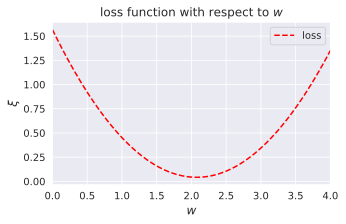

In [5]:
# Plot the loss vs the given weight w

# Vector of weights for which we want to plot the loss
ws = np.linspace(0, 4, num=100)  # weight values
# loss for each weight in ws
loss_ws = np.vectorize(lambda w: loss(nn(x, w) , t))(ws)

# Plot
plt.figure(figsize=(5, 3))
plt.plot(ws, loss_ws, 'r--', label='loss')
plt.xlabel('$w$', fontsize=12)
plt.ylabel('$\\xi$', fontsize=12)
plt.title('loss function with respect to $w$')
plt.xlim(0, 4)
plt.legend()
plt.show()
#

## Minimizing the loss function

For a simple loss function like in this example, you can see easily what the optimal weight should be. However, in practice the error surface can be quite complex with many hills and valleys, or have a high dimensionality (each parameter adds a new dimension). This is why we use [optimization techniques](https://en.wikipedia.org/wiki/Mathematical_optimization) like gradient descent to find the minimum of the error function.

### Gradient descent

One optimization algorithm commonly used to train neural networks is the [gradient descent](http://en.wikipedia.org/wiki/Gradient_descent) algorithm. The gradient descent algorithm works by taking the [gradient](http://en.wikipedia.org/wiki/Gradient) ([derivative](http://en.wikipedia.org/wiki/Derivative)) of the loss function $\xi$ with respect to the parameters at a specific position on this loss function, and updates the parameters in the direction of the negative gradient (down along the loss function).
The parameter $w$ is iteratively updated by taking steps proportional to the negative of the gradient:
$$
w(k+1) = w(k) - \Delta w(k)
$$

With $w(k)$ the value of $w$ at iteration $k$ during the gradient descent.  
$\Delta w$ is defined as:
$$
\Delta w = \mu \frac{\partial \xi}{\partial w}
$$

With $\mu$ the learning rate, which is how big of a step you take along the gradient, and ${\partial \xi}/{\partial w}$ the gradient of the loss function $\xi$ with respect to the weight $w$. For each sample $i$ this gradient can be splitted according to the [chain rule](http://en.wikipedia.org/wiki/Chain_rule) into:

$$
\frac{\partial \xi_i}{\partial w} = \frac{\partial \xi_i}{\partial y_i} \frac{\partial y_i}{\partial w}
$$

Where $\xi_i$ is the squared error loss, so the ${\partial \xi_i}/{\partial y_i}$ term can be written as:

$$
\frac{\partial \xi_i}{\partial y_i} = \frac{\partial (t_i - y_i)^2}{\partial y_i} = - 2 (t_i - y_i) = 2 (y_i - t_i)
$$

And since $y_i = x_i \cdot w$ we can write ${\partial y_i}/{\partial w}$ as:

$$
\frac{\partial y_i}{\partial w} = \frac{\partial (x_i \cdot w)}{\partial w} = x_i
$$

So the full update function $\Delta w$ for sample $i$ will become:

$$
\Delta w = \mu \cdot \frac{\partial \xi_i}{\partial w} = \mu \cdot 2 x_i (y_i - t_i)
$$

In the batch processing, we just add up all the gradients for each sample:

$$
\Delta w = \mu * 2 * \frac{1}{N} \sum_{i=1}^{N} x_i (y_i - t_i)
$$

The gradient descent algorithm is typically initialised by starting with random initial parameters. After initiating these parameters we can start updating these parameters with $\Delta w$ until convergence. The learning rate needs to be tuned separately as a hyperparameter for each neural network.

The gradient ${\partial \xi}/{\partial w}$ is implemented by the `gradient(w, x, t)` function. $\Delta w$ is computed by the `delta_w(w_k, x, t, learning_rate)`. The loop below performs 4 iterations of gradient descent while printing out the parameter value and current loss.

In [6]:
def gradient(w, x, t):
    """Gradient function. (Remember that y = nn(x, w) = x * w)"""
    return 2 * x * (nn(x, w) - t)


def delta_w(w_k, x, t, learning_rate):
    """Update function delta w"""
    return learning_rate * np.mean(gradient(w_k, x, t))


# Initial weight parameter
w = np.random.rand()
# Set the learning rate
learning_rate = 0.9

# Perform the gradient descent updates, and print the weights and loss:
nb_of_iterations = 4  # number of gradient descent updates
w_loss = [(w, loss(nn(x, w), t))] # Keep track of weight and loss values
for i in range(nb_of_iterations):
    dw = delta_w(w, x, t, learning_rate)  # Delta w update
    w = w - dw  # Update the current weight parameter
    w_loss.append((w, loss(nn(x, w), t)))  # Save weight and loss

# Print the final w, and loss
for i in range(0, len(w_loss)):
    print(f'w({i}): {w_loss[i][0]:.4f} \t loss: {w_loss[i][1]:.4f}')

w(0): 0.1380 	 loss: 1.3710
w(1): 1.3722 	 loss: 0.2174
w(2): 1.8205 	 loss: 0.0651
w(3): 1.9834 	 loss: 0.0451
w(4): 2.0426 	 loss: 0.0424


Notice in the previous outcome that the gradient descent algorithm quickly converges towards the target value around $2.0$. Let's try to plot these iterations of the gradient descent algorithm to visualize it.

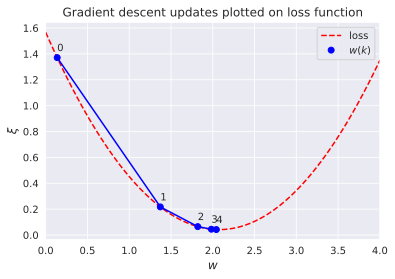

In [7]:
# Visualise the gradient descent updates
plt.figure(figsize=(6, 4))
plt.plot(ws, loss_ws, 'r--', label='loss')  # Loss curve
# Plot the updates
for i in range(0, len(w_loss)-1):
    w1, c1 = w_loss[i]
    w2, c2 = w_loss[i+1]
    plt.plot(w1, c1, 'bo')
    plt.plot([w1, w2],[c1, c2], 'b-')
    plt.text(w1, c1+0.05, f'${i}$')
plt.plot(w2, c2, 'bo', label='$w(k)$')
plt.text(w2, c2+0.05, f'${i+1}$')
# Show figure
plt.xlabel('$w$', fontsize=12)
plt.ylabel('$\\xi$', fontsize=12)
plt.title('Gradient descent updates plotted on loss function')
plt.xlim(0, 4)
plt.legend(loc=1)
plt.show()
#

#### Gradient descent updates

The previous figure shows the gradient descent updates of the weight parameters for 4 iterations. The blue dots represent the weight parameter values $w(k)$ at iteration $k$. Notice how the update differs from the position of the weight and the gradient at that point. The first update takes a much larger step than the second update because the gradient at $w(0)$ is much larger than the gradient at $w(1)$.

The regression line fitted by gradient descent with 10 iterations is shown in the figure below. The resulting line fitted with gradient descent (full red) lies close to the original line that generated the samples(dashed blue). Notice that both lines go through point $(0,0)$, this is because we didn't have a bias term, which represents the intercept, the intercept at $x=0$ is thus $t=0$.

In [8]:
w = np.random.rand()
# Start performing the gradient descent updates
nb_of_iterations = 10  # number of gradient descent updates
for i in range(nb_of_iterations):
    dw = delta_w(w, x, t, learning_rate)  # get the delta w update
    w = w - dw  # update the current weight parameter

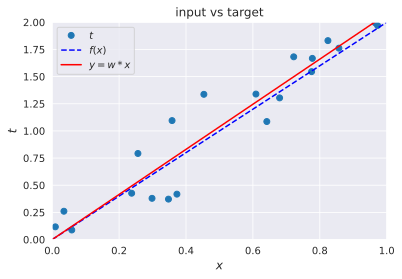

In [9]:
# Plot the fitted line agains the target line
plt.figure(figsize=(6, 4))
# Plot the target t versus the input x
plt.plot(x, t, 'o', label='$t$')
# Plot the initial line
plt.plot([0, 1], [f(0), f(1)], 'b--', label='$f(x)$')
# plot the fitted line
plt.plot([0, 1], [0*w, 1*w], 'r-', label='$y = w * x$')
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$t$', fontsize=12)
plt.title('input vs target')
plt.legend(loc=2)
plt.ylim(0, 2)
plt.xlim(0, 1)
plt.show()
#

This was the first part of a 4-part tutorial on how to implement neural networks from scratch in Python:
- [Part 1: Gradient descent (this)]({% post_url /blog/neural_net_implementation/2015-06-12-neural-network-implementation-part01 %})
- [Part 2: Classification]({% post_url /blog/neural_net_implementation/2015-06-13-neural-network-implementation-part02 %})
- [Part 3: Hidden layers trained by backpropagation]({% post_url /blog/neural_net_implementation/2015-06-14-neural-network-implementation-part03 %})
- [Part 4: Vectorization of the operations]({% post_url /blog/neural_net_implementation/2015-06-15-neural-network-implementation-part04 %})
- [Part 5: Generalization to multiple layers]({% post_url /blog/neural_net_implementation/2015-06-16-neural-network-implementation-part05 %})

The tutorials are generated from Python 3 [Jupyter notebook](http://jupyter.org/) files, which will be linked to at the end of each chapter so that you can adapt and run the examples yourself. The neural networks themselves are implemented using the Python [NumPy](http://www.numpy.org/) library which offers efficient implementations of linear algebra functions such as vector and matrix multiplications. Illustrative plots are generated using [Matplotlib](http://matplotlib.org/) and [Seaborn](https://seaborn.pydata.org/). Libraries were installed via the [Anaconda](https://www.anaconda.com/download/) Python distribution.

Note that the code input cells in this blog can be collapsed or expanded by clicking on the button in the top right of each cell.

In [10]:
# Python package versions used
%load_ext watermark
%watermark --python
%watermark --iversions
#

Python implementation: CPython
Python version       : 3.9.4
IPython version      : 7.23.1

seaborn   : 0.11.1
matplotlib: 3.4.2
numpy     : 1.20.2



This post at <a rel="canonical" href="https://peterroelants.github.io/posts/neural-network-implementation-part01/">peterroelants.github.io</a> is generated from an IPython notebook file. [Link to the full IPython notebook file](https://github.com/peterroelants/peterroelants.github.io/blob/main/notebooks/neural_net_implementation/neural-network-implementation-part01.ipynb)